# Importing Important Libraries
```
1. I have imported the stopwords from nltk and copied more of them from internet
2. Instead of split() function, I am using the tokenizer
3. Instead of manually downloading the data, I have downloaded it using sklearn.datasets.fetch_20newsgroups
```

In [1]:
import nltk
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
# Instead of the link, I have fetched the data through sklearn itself
newsgroups = fetch_20newsgroups() 

# These are the stopwords and punctuations which we don't want to include in out vocabulary.
stops = set(stopwords.words('english'))
punctuations = list(string.punctuation)
stops.update(punctuations)

In [3]:
# More stop words from the internet
df = pd.read_csv("stop_words_english.txt", sep=" ")
more_stops = []
for s in df.iloc[:,0]:
    more_stops.append(s.strip())
stops.update(more_stops)

In [4]:
# all_documents contains all the "X" data in un-tokenized form
all_documents = newsgroups.data

# all_cateories contain all the "Y" data
all_categories = newsgroups.target

# Modified the all_documents to a form in which we have list of list of words(tokenized data for each document)
all_documents_modified=[word_tokenize(doc) for doc in all_documents]

In [5]:
# Splitting these documents in train and test data.
x_train, x_test, y_train, y_test=train_test_split(all_documents_modified, all_categories, random_state=1)

In [6]:
# all_words will contain all the words from all our tokenized documents
all_words = []

for doc in x_train:
    for word in doc:
        # Excluding all stop words, words with length less than 2 and words that are not helping much in classification
        if (word.lower() not in stops) and len(word) > 2 and word[0]!="'" and word!="n't" and word[0]!=".":
            all_words.append(word)

In [7]:
# This function accepts a list and returns a dictionary in which keys are the words and values are frequency of that word
def freq_dict(all_words):
    dic = dict()
    for word in all_words:
        dic[word] = dic.get(word,0)+1
    return dic

dic = freq_dict(all_words) # dic will have frequency of all the words

In [8]:
# dic.keys() and dic.values() to two separate variables
freq = np.array([i for i in dic.values()])
words = np.array([i for i in dic.keys()])

# Sorted both the arrays using np.sort() and np.argsort() and then reversed to obtain array in descending order
words = words[np.argsort(freq)][::-1]
freq = np.sort(freq)[::-1]

# Frequency Distribution of words

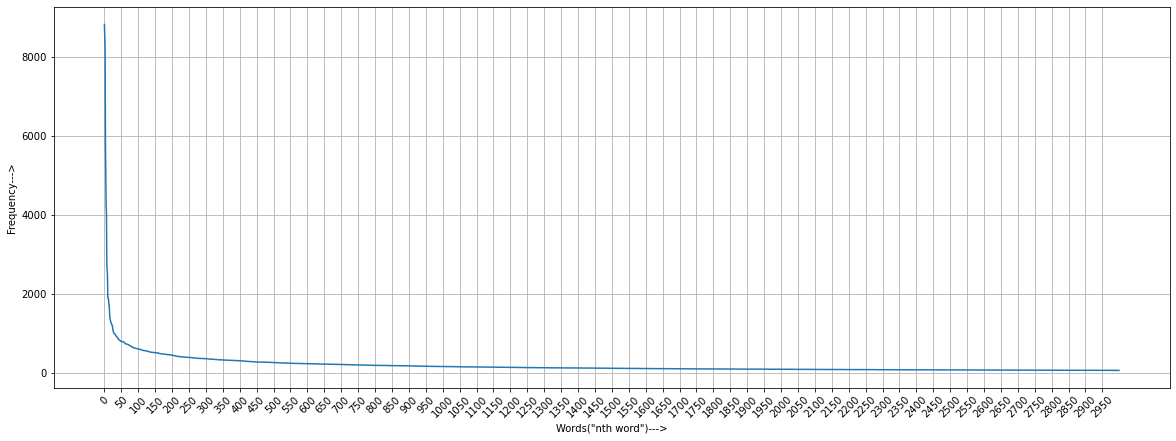

In [9]:
# Frequency distribution graph to observe the frequency trend

# Graph Limits
lower_limit = 0    
upper_limit = 3000    
difference_between_each_xtick= 50
# Adjusting size of the graph for more clarity
plt.figure(figsize=(20, 7))
# Plotting
plt.plot(np.arange(len(freq))[lower_limit:upper_limit], freq[lower_limit:upper_limit])
# Labelling
plt.xlabel('Words("nth word")--->')
plt.ylabel("Frequency--->")
# Adjusting the xticks
plt.xticks(np.arange(lower_limit, upper_limit, 50), rotation=45)
plt.grid()
plt.show()

In [10]:
# features contains all the top words which are most frequently used in all our documents
features = words[20:100000] # Removing very high frequency words as they may be present in all the documents
freq[20], freq[10000]

(1256, 16)

In [11]:
# data_modifier takes the patameters x_train or x_test and the list of all features and converts it into a TEXT-CLASSIFICATION-FRIENDLY structure
# TEXT-CLASSIFICATION-FRIENDLY structure means it converts the data into a 2-D array which contains the frequency of that feature in that perticular document
# rows are the documents and columns are the features.
def data_modifier(x_data, features):
    # modified_data currently have a ZEROS numpy array whose shape is (len(x_data), len(features))
    modified_data = np.zeros((len(x_data), len(features)))
    count = 0 # to keep track of progress of algorithm
    max_count = len(x_data)
    for i in range(len(x_data)):
        # looping over each and every row in the x_data
        current_doc = x_data[i] # current_doc contains the current document on which we are iterating
        d = dict() # contains the frequency of all the elements in our current_doc.
        for word in current_doc:
            d[word] = d.get(word,0)+1
        for j in range(len(features)):
            modified_data[i][j] = d.get(features[j],0)
        count+=1
#         print("progress: ", (count*100)/max_count, "%") # This statement just prints the progress of our data_modifier function
    return modified_data # finally return the modified array

In [12]:
x_train_modified = data_modifier(x_train, features)
x_test_modified= data_modifier(x_test, features)

# Inbuilt Multinomial Naive Bayes Classifier

In [13]:
# Inbuilt Multinomial naive bayes classifier
clf = MultinomialNB()
clf.fit(x_train_modified, y_train)
clf.score(x_test_modified, y_test)

0.8925415341109932

# Writing our own Naive Bayes Classifier

In [15]:
# fit function takes the training data and gives you a dictionary whose keys are the different classes available to classify
# Each key --> value is another dictionary, whose keys are all the features available to us
# value corresponding to each key is sum of all the row of training data corresponding to the current class
def fit(x_train, y_train):
    count = dict()
    for i in range(20):
        needed_docs = x_train[y_train==i] # All the documents we need to work upon corresponding to the class i
        count[i] = dict()
        count[i]['total'] = 0 # Total number of words in class i
        for j in range(len(features)):
            count[i][features[j]] = needed_docs[:,j].sum() # How many times jth feature is coming corresponding to class i
            count[i]['total']+=count[i][features[j]] # Total number of words in class i
    return count # Returning the dictionary

#This "Probability" function takes takes the dictionary which was originally returned by fit function, the current data point and the current class as its parameters
def probability(dictionary, x, current_class):
    probas_for_each_word=[]
    for i in range(len(x)):
        #iterating through each feature.
        if x[i] != 0: # Skipping those features whose value corresponding to the current document is 0
            numerator = dictionary[current_class][features[i]] # Denotes that how many times that ith feature is occuring in "current_class"
            # This numerator of our NON LOGARITHMIC PROBABILITY
            denominator = dictionary[current_class]['total'] # Denotes the total number of words in the current class
            # This denominator of our NON LOGARITHMIC PROBABILITY
            proba = np.log((numerator+1)/(denominator+len(x)))
            # "proba" which stores the logarithmic probability which also includes the laplace correction
            # Here "1" with the numerator and len(x) with denominator denotes the laplace correction
            probas_for_each_word.append(proba) # appended "proba" to the probas_for_each_word array
    return sum(probas_for_each_word) # Returning the logarithmic sum of all the probabilities

# The predict_single function takes a perticular data point "x" from "predict" function and a dictionary which was obtained from fit function
def predict_single(dic,x):
    classes = dictionary.keys() # Maintains all the possible different classes available
    best_p = -1000
    best_class = -1
    # Initiated best_p and best_class variables with negative values because we want to consider maximum valued probabilities
    # In the first run itself they will be replaced by positive values
    # "best_p" variable denotes the best probability uptill now and "best_class" denotes the best class uptill now
    first_run = True # This boolean variable is taken keeping initial negative values in mind
    for current_class in classes:
        # Iterating through each and every class in all possible classes.
        p_current_class = probability(dic, x, current_class)
        # p_current_class denotes the probability of current class.
        if (first_run or p_current_class > best_p):
            # If the probability of current class is higher than the best probability
            # we will update the best probability and best class to the probability of current class and the current class
            best_p = p_current_class
            best_class = current_class
        first_run = False
    return best_class # Returning the best predicted class for the current data point

# The predict function takes testing data and a dictionary as its input, where the dictionary is the one returned from fit function
def predict(x_test, dic):
    y_pred = [] # Maintains all the predicted classes for provided testing data
    for doc in x_test:
        # Iterating each document in testing data.
        y_pred.append(predict_single(dic,doc))
        # For each testing data point, we will append the value of predicted class to y_pred
        # We will get that value from predict_single function
    return y_pred # Returning the predicted data

In [16]:
# Calling the fit function for the modified data
dictionary = fit(x_train_modified, y_train)

In [17]:
# Storing the predicted values
y_predicted = predict(x_test_modified, dictionary)

In [18]:
# Printing the confusion matrix for our own Naive Bayes Classifier
for i in confusion_matrix(y_true=y_test, y_pred=y_predicted):
    for j in i:
        print(j, end="    ")
    print()

103    0    0    0    0    0    0    0    0    0    0    0    0    0    0    5    0    3    0    3    
0    126    1    5    2    9    1    0    0    0    0    4    0    1    2    1    0    0    0    0    
0    3    97    9    1    26    1    0    0    0    0    2    0    0    0    0    0    0    0    0    
0    3    2    125    6    5    3    0    0    0    0    4    2    0    0    1    0    1    0    0    
0    1    0    2    124    1    4    1    0    0    0    3    0    1    0    0    0    0    1    0    
0    3    0    0    2    145    0    0    1    0    0    0    0    1    0    0    0    0    1    0    
0    3    0    7    4    2    95    3    2    2    3    6    9    1    1    1    2    1    5    0    
0    0    0    1    0    0    4    120    1    1    1    0    3    0    2    1    1    0    2    0    
0    0    0    0    0    0    2    0    125    0    0    0    0    0    0    0    4    0    0    0    
0    1    0    0    0    0    0    0    0    128    2    0    0    1    0 

In [19]:
# Printing the classification report for our own Naive Bayes Classifier
print(classification_report(y_true=y_test, y_pred=y_predicted))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91       114
           1       0.85      0.83      0.84       152
           2       0.97      0.70      0.81       139
           3       0.79      0.82      0.81       152
           4       0.87      0.90      0.89       138
           5       0.75      0.95      0.84       153
           6       0.85      0.65      0.73       147
           7       0.94      0.88      0.91       137
           8       0.97      0.95      0.96       131
           9       0.96      0.95      0.96       135
          10       0.95      0.98      0.96       136
          11       0.85      0.99      0.91       145
          12       0.90      0.82      0.85       157
          13       0.96      0.96      0.96       151
          14       0.92      0.97      0.94       155
          15       0.83      0.96      0.89       159
          16       0.87      0.98      0.92       140
          17       0.92    